In [82]:
import matplotlib.pyplot as plt
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
import os
dirname = os.getcwd()
plt.style.use('dark_background')


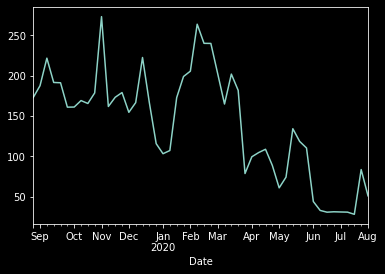

In [84]:
# My Personal Power Usage
filename = os.path.join(dirname, 'data.csv')

data = pd.read_csv(open(filename,'rb+'),index_col="Date")['Quantity']
data.index = pd.to_datetime(data.index, format='%m/%d/%Y')

#data = data.resample('W').sum()
data.resample('W').sum().plot()
data = data.to_frame()

In [86]:
print(data.describe())
print('Variance: ',data.var())

Quantity
count  347.000000
mean    20.269228
std     10.790766
min      3.000000
25%     11.292500
50%     21.142000
75%     28.133000
max     52.520000
Variance:  Quantity    116.440631
dtype: float64


<AxesSubplot:title={'center':'Daily Usage 7 Day Moving Average'}, xlabel='Date'>

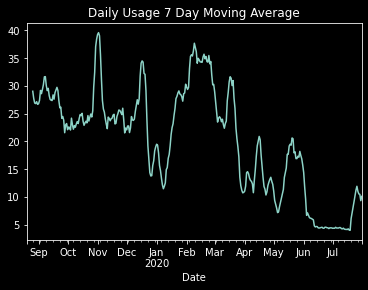

In [87]:
#Use a Moving Avg for daily data:
data['MA'] = data.rolling(window=7).mean()
plt.title("Daily Usage 7 Day Moving Average")
data['MA'].plot()

In [69]:
print(data['MA'].describe())
print('Variance: ',data['MA'].var())

count    341.000000
mean      20.272979
std        9.519841
min        4.001143
25%       12.176000
50%       22.584000
75%       27.395000
max       39.575571
Name: MA, dtype: float64
Variance:  90.62737536134185


<AxesSubplot:title={'center':'Weekly Seasonality'}, xlabel='Date'>

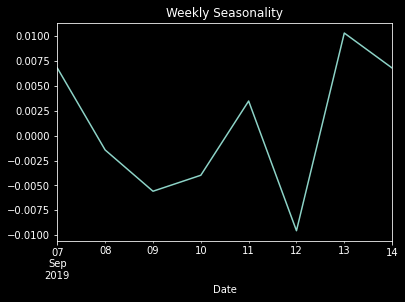

In [90]:
#Weekly Seasonality
data = data['MA'].dropna()
plt.title("Weekly Seasonality")
result = seasonal_decompose(data, model='additive',period=7)
result.seasonal['9/7/19':'9/14/19'].plot()


<AxesSubplot:title={'center':'Seasonality'}, xlabel='Date'>

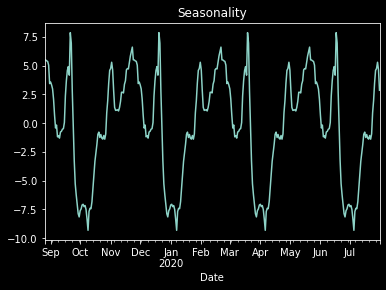

In [97]:
#Seasonality (90 Day)
plt.title("Seasonality")
result = seasonal_decompose(data, model='additive',period=(90))
result.seasonal.plot()
#Note higher power costs (avg) durring winter (as expected)

<AxesSubplot:xlabel='Date'>

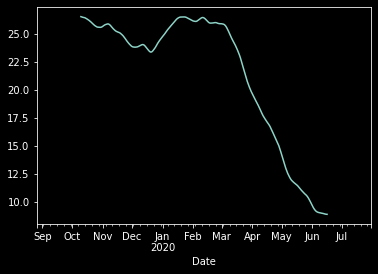

In [96]:
# The trend is not stationary, due to moving back home durring COVID
result.trend.plot()

<AxesSubplot:title={'center':'Weekly AEP demand'}, xlabel='Datetime'>

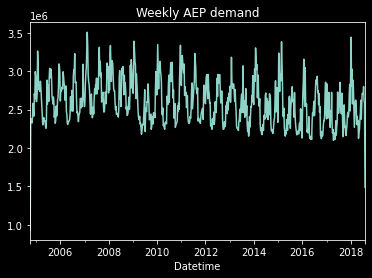

In [99]:
#Larger dataset for better analysis
plt.title("Weekly AEP demand")
data = pd.read_csv(open('/media/saros/Store/Dev/Power-Usage/AEP_hourly.csv','r'),index_col="Datetime")['AEP_MW']
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %H:%M:%S')

data = data.resample('W').sum()
data.plot()


In [100]:
# Mean/Variance for the raw data
# Results in a high variance
mean = data.mean()
var = data.var()
print("Mean was  ", mean)
print("Variance was  " ,  var)

Mean was   2599823.6887966804
Variance was   83127453734.27837


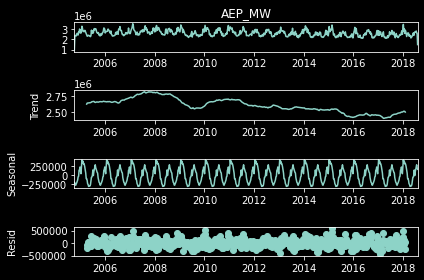

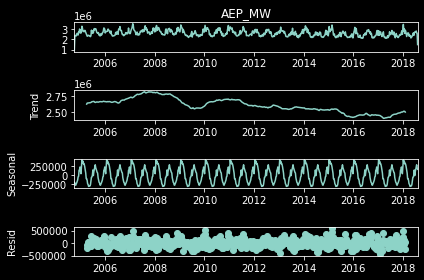

In [104]:
result = seasonal_decompose(data, model='additive',period=52)
result.plot()

<AxesSubplot:title={'center':'AEP Seasonality'}, xlabel='Datetime'>

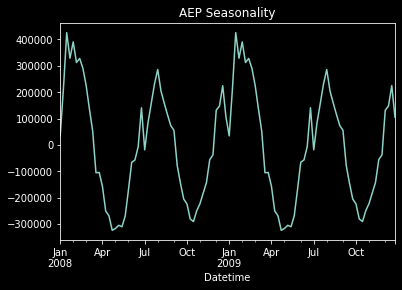

In [107]:
plt.title("AEP Seasonality")
result.seasonal['2008':'2009'].plot()

<AxesSubplot:title={'center':'AEP Trend'}, xlabel='Datetime'>

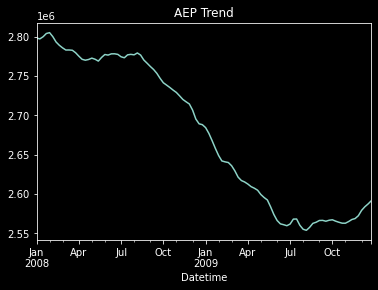

In [108]:
plt.title("AEP Trend")
result.trend.plot()